# Piano Test

## Training Model

In [1]:
import pandas as pd

In [7]:
import _pickle as cPickle
import numpy as np
from scipy.io.wavfile import read
from sklearn.cluster import KMeans
import warnings
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
warnings.filterwarnings("ignore")

def extract_features(audio,rate):  
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,41,appendEnergy = True,nfft=1500)
    mfcc_feat=np.array(pd.DataFrame(mfcc_feat).drop(0,axis=1))
    mfcc_feat = preprocessing.scale(mfcc_feat)
    return mfcc_feat 

dest = "clusters_p/"

train_file = "train_p.txt"        


file_paths = open(train_file,'r',encoding='utf-8-sig')

count = 1


features = np.asarray(())
for path in file_paths:    
    path = path.strip()   
    print (path)
    
    # read the audio
    sr,audio = read(path)
    
    # extract 40 dimensional MFCC & delta MFCC features
    vector   = extract_features(audio,sr)
    
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    # when features of 5 files of speaker are concatenated, then do model training
    if count == 4:    
        kmeans = KMeans(n_clusters= 16, max_iter = 200, algorithm="full",n_init = 3)
        kmeans.fit(features)
        
        # dumping the trained gaussian model
        picklefile = path.split("/")[2]+".kme"
        print (picklefile)
        cPickle.dump(kmeans,open(dest + picklefile,'wb'))
        print ('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)    
        features = np.asarray(())
        count = 0
    count = count + 1

data_p/alice/p_1.wav
data_p/alice/p_1_0.wav
data_p/alice/p_1_1.wav
data_p/alice/p_1_2.wav
p_1_2.wav.kme
+ modeling completed for speaker: p_1_2.wav.kme  with data point =  (7284, 25)
data_p/simrita/p_2.wav
data_p/simrita/p_2_0.wav
data_p/simrita/p_2_1.wav
data_p/simrita/p_2_2.wav
p_2_2.wav.kme
+ modeling completed for speaker: p_2_2.wav.kme  with data point =  (8039, 25)
data_p/hitesh/p_3.wav
data_p/hitesh/p_3_0.wav
data_p/hitesh/p_3_1.wav
data_p/hitesh/p_3_2.wav
p_3_2.wav.kme
+ modeling completed for speaker: p_3_2.wav.kme  with data point =  (8240, 25)


## Testing Model

In [8]:
import os
import _pickle as cPickle
import numpy as np
from scipy.io.wavfile import read
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
import matplotlib.pyplot as plt

def extract_features(audio,rate):
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,41,appendEnergy = True,nfft=1500)
    mfcc_feat=np.array(pd.DataFrame(mfcc_feat).drop(0,axis=1))
    mfcc_feat = preprocessing.scale(mfcc_feat)
    return mfcc_feat

modelpath = "clusters_p/"

test_file = "test_p.txt"        

file_paths = open(test_file,'r',encoding='utf-8-sig')


gmm_files = [os.path.join(modelpath,fname) for fname in 
              os.listdir(modelpath) if fname.endswith('.kme')]

#Load the Gaussian gender Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [fname.split("\\")[-1].split(".kme")[0] for fname 
              in gmm_files]

# Read the test directory and get the list of test audio files 
for path in file_paths:   
    
    path = path.strip()   
    print (path)
    sr,audio = read(path)
    vector   = extract_features(audio,sr)
    out = []
    for x in (range(0,vector.shape[0],10)):
        z = vector[x:x+20]
        log_likelihood = np.zeros(len(models)) 
        for i in range(len(models)):
            kmeans    = models[i]         #checking with each model one by one
            scores = np.array(kmeans.score(z))
            log_likelihood[i] = scores
        winner = np.argmax(log_likelihood)
        out.append(winner)
    pd.DataFrame(out)[0].unique()
    print(pd.DataFrame(out)[0].value_counts())
    print("Speaker classified: ", speakers[(pd.DataFrame(out)[0].value_counts().index[0])])
    f,ax = plt.subplots(1,1,figsize=(70,20))
    ax.scatter(x = np.arange(0,vector.shape[0],10),y=out)
    plt.show()

data_p/alice/p_1_3.wav
2    193
0      9
1      5
Name: 0, dtype: int64
Speaker classified:  clusters_p/p_1_2.wav


<Figure size 7000x2000 with 1 Axes>

data_p/simrita/p_2_3.wav
1    211
2      2
0      2
Name: 0, dtype: int64
Speaker classified:  clusters_p/p_2_2.wav


<Figure size 7000x2000 with 1 Axes>

data_p/hitesh/p_3_3.wav
0    197
2      7
1      5
Name: 0, dtype: int64
Speaker classified:  clusters_p/p_3_2.wav


<Figure size 7000x2000 with 1 Axes>

1    1438
2    1104
0     337
Name: 0, dtype: int64
Speaker classified:  clusters_p/p_2_2.wav


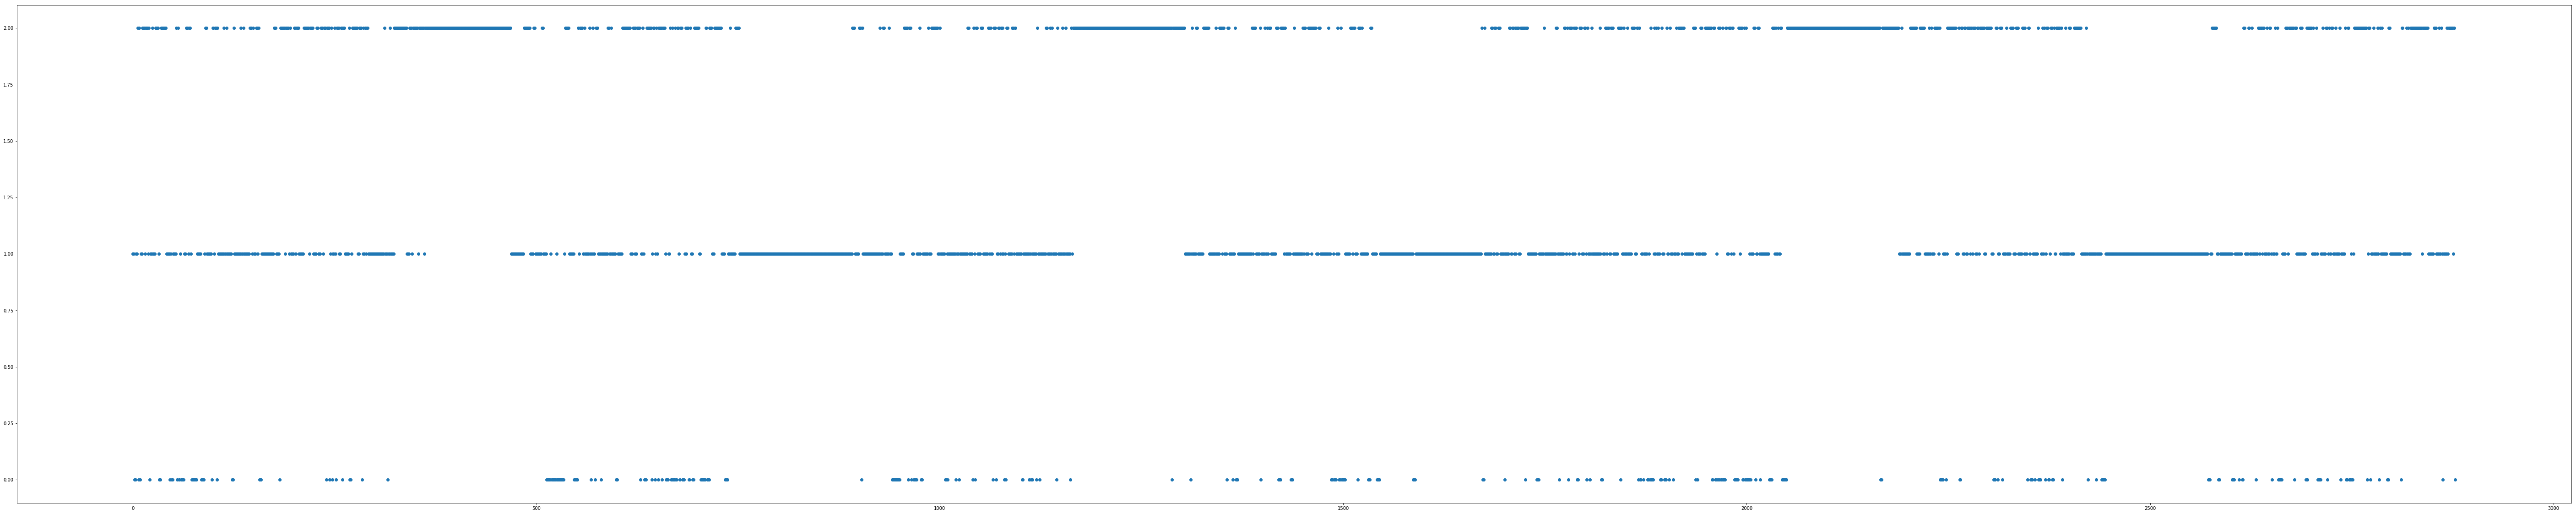

In [10]:
modelpath = "clusters_p/"


gmm_files = [os.path.join(modelpath,fname) for fname in 
              os.listdir(modelpath) if fname.endswith('.kme')]

#Load the Gaussian gender Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [fname.split("\\")[-1].split(".kme")[0] for fname 
              in gmm_files]

# Read the test directory and get the list of test audio files 

sr,audio = read("p_3.wav")
vector   = extract_features(audio,sr)
out = []
for x in (range(0,vector.shape[0],1)):
    z = vector[x]
    log_likelihood = np.zeros(len(models)) 
    for i in range(len(models)):
        kmeans    = models[i]         #checking with each model one by one
        scores = np.array(kmeans.score(z.reshape(1,-1)))
        log_likelihood[i] = scores
    winner = np.argmax(log_likelihood)
    out.append(winner)
pd.DataFrame(out)[0].unique()
print(pd.DataFrame(out)[0].value_counts())
print("Speaker classified: ", speakers[(pd.DataFrame(out)[0].value_counts().index[0])])
f,ax = plt.subplots(1,1,figsize=(100,20))
ax.scatter(x = np.arange(0,vector.shape[0],1),y=out)
plt.show()

In [18]:
time = np.arange(0,vector.shape[0],1)
time = time.tolist()

from itertools import groupby
L = out
grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
cluster_time = []
time_seperate = []
k=0
counter=0
for i in grouped_L:
    cluster_time.append(i[1])
for i in cluster_time:
    j=0
    first = time[k]
    while (j != i):
        k +=1
        j+=1
    last = time[k-1]
    time_seperate.append([first,last,i,grouped_L[counter][0]])
    counter +=1
def sortThird(val): 
    return val[2] 
time_seperate.sort(key = sortThird, reverse = True)

cluster_0 = []
cluster_1 = []
cluster_2 = []

for i in range (0,len(time_seperate)):
    if time_seperate[i][3] == 1:
        cluster_1.append(time_seperate[i])
    if time_seperate[i][3] == 0:
        cluster_0.append(time_seperate[i])
    if time_seperate[i][3] == 2:
        cluster_2.append(time_seperate[i])        
        
cluster_slice = [cluster_0[0],cluster_1[0],cluster_2[0]]
from pydub import AudioSegment
for i in range(0,len(cluster_slice)):
    t1 = cluster_slice[i][0]*10/2
    t2 = cluster_slice[i][1]*10/2
    newAudio = AudioSegment.from_wav("p_3.wav")
    newAudio = newAudio[t1:t2]
    newAudio.export('p_3_'+str(i)+'.wav', format="wav")

## Original Audio

In [19]:
import librosa
# function to load files and extract features
file_name = "p_3.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

## Sliced Audio: Detecting Notes

In [20]:
import librosa
# function to load files and extract features
file_name = "p_3_0.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

In [21]:
import librosa
# function to load files and extract features
file_name = "p_3_1.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

In [22]:
import librosa
# function to load files and extract features
file_name = "p_3_2.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

# Human Voice

## Training Model

In [23]:
import pandas as pd 

In [25]:
import _pickle as cPickle
import numpy as np
from scipy.io.wavfile import read
from sklearn.cluster import KMeans
import warnings
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
warnings.filterwarnings("ignore")

def extract_features(audio,rate):  
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,41,appendEnergy = True,nfft=1500)
    mfcc_feat=np.array(pd.DataFrame(mfcc_feat).drop(0,axis=1))
    mfcc_feat = preprocessing.scale(mfcc_feat)
    return mfcc_feat 

dest = "clusters/"

train_file = "train.txt"        


file_paths = open(train_file,'r',encoding='utf-8-sig')

count = 1


features = np.asarray(())
for path in file_paths:    
    path = path.strip()   
    print (path)
    
    # read the audio
    sr,audio = read(path)
    
    # extract 40 dimensional MFCC & delta MFCC features
    vector   = extract_features(audio,sr)
    
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    # when features of 5 files of speaker are concatenated, then do model training

    if count == 5:    
        kmeans = KMeans(n_clusters= 16, max_iter = 200, algorithm="full",n_init = 3)
        kmeans.fit(features)
        
        # dumping the trained gaussian model
        picklefile = path.split("/")[2]+".kme"
        print (picklefile)
        cPickle.dump(kmeans,open(dest + picklefile,'wb'))
        print ('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)    
        features = np.asarray(())
        count = 0
    count = count + 1

data/alice/al_1.wav
data/alice/al_2.wav
data/alice/al_3.wav
data/alice/al_4.wav
data/alice/al_5.wav
al_5.wav.kme
+ modeling completed for speaker: al_5.wav.kme  with data point =  (9873, 25)
data/simrita/si_1.wav
data/simrita/si_2.wav
data/simrita/si_3.wav
data/simrita/si_4.wav
data/simrita/si_5.wav
si_5.wav.kme
+ modeling completed for speaker: si_5.wav.kme  with data point =  (10482, 25)
data/hitesh/hi_1.wav
data/hitesh/hi_2.wav
data/hitesh/hi_3.wav
data/hitesh/hi_4.wav
data/hitesh/hi_5.wav
hi_5.wav.kme
+ modeling completed for speaker: hi_5.wav.kme  with data point =  (9903, 25)


## Testing Model

data/alice/al_6.wav
0    166
1     23
2     12
Name: 0, dtype: int64
Speaker classified:  clusters/al_5.wav


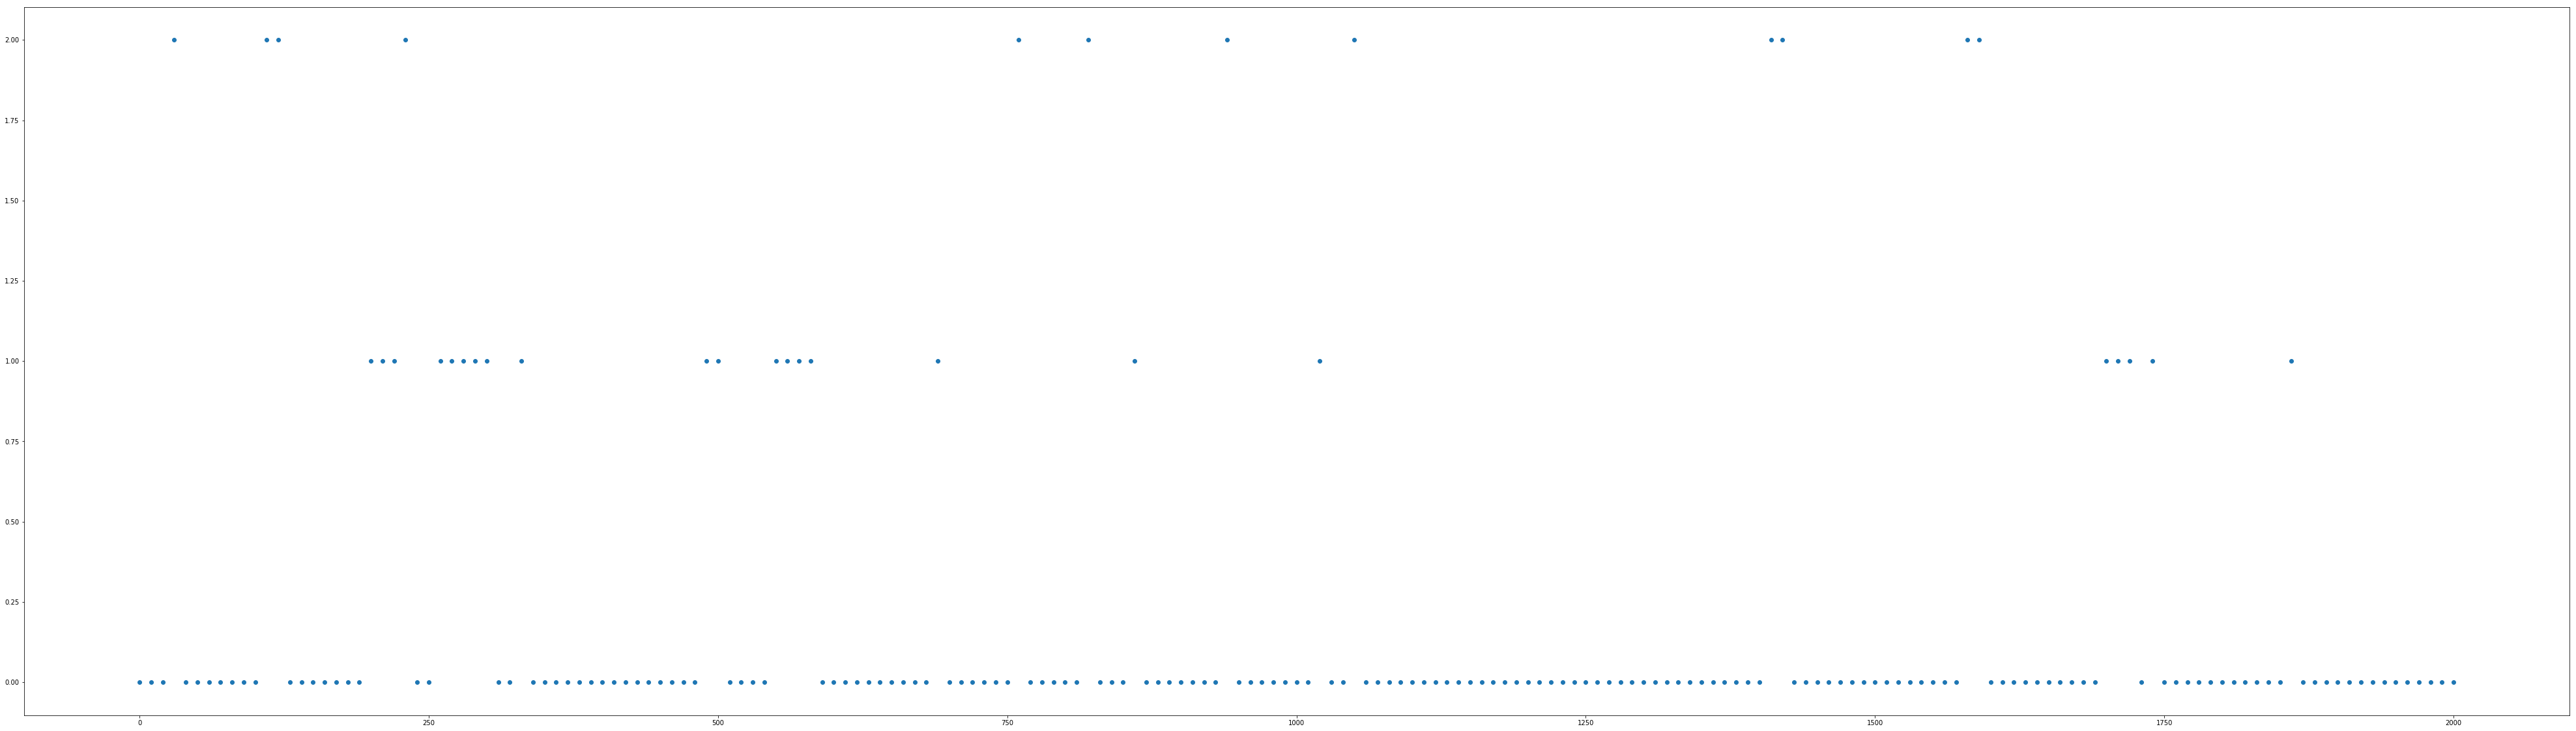

data/simrita/si_6.wav
2    210
0     13
1      1
Name: 0, dtype: int64
Speaker classified:  clusters/si_5.wav


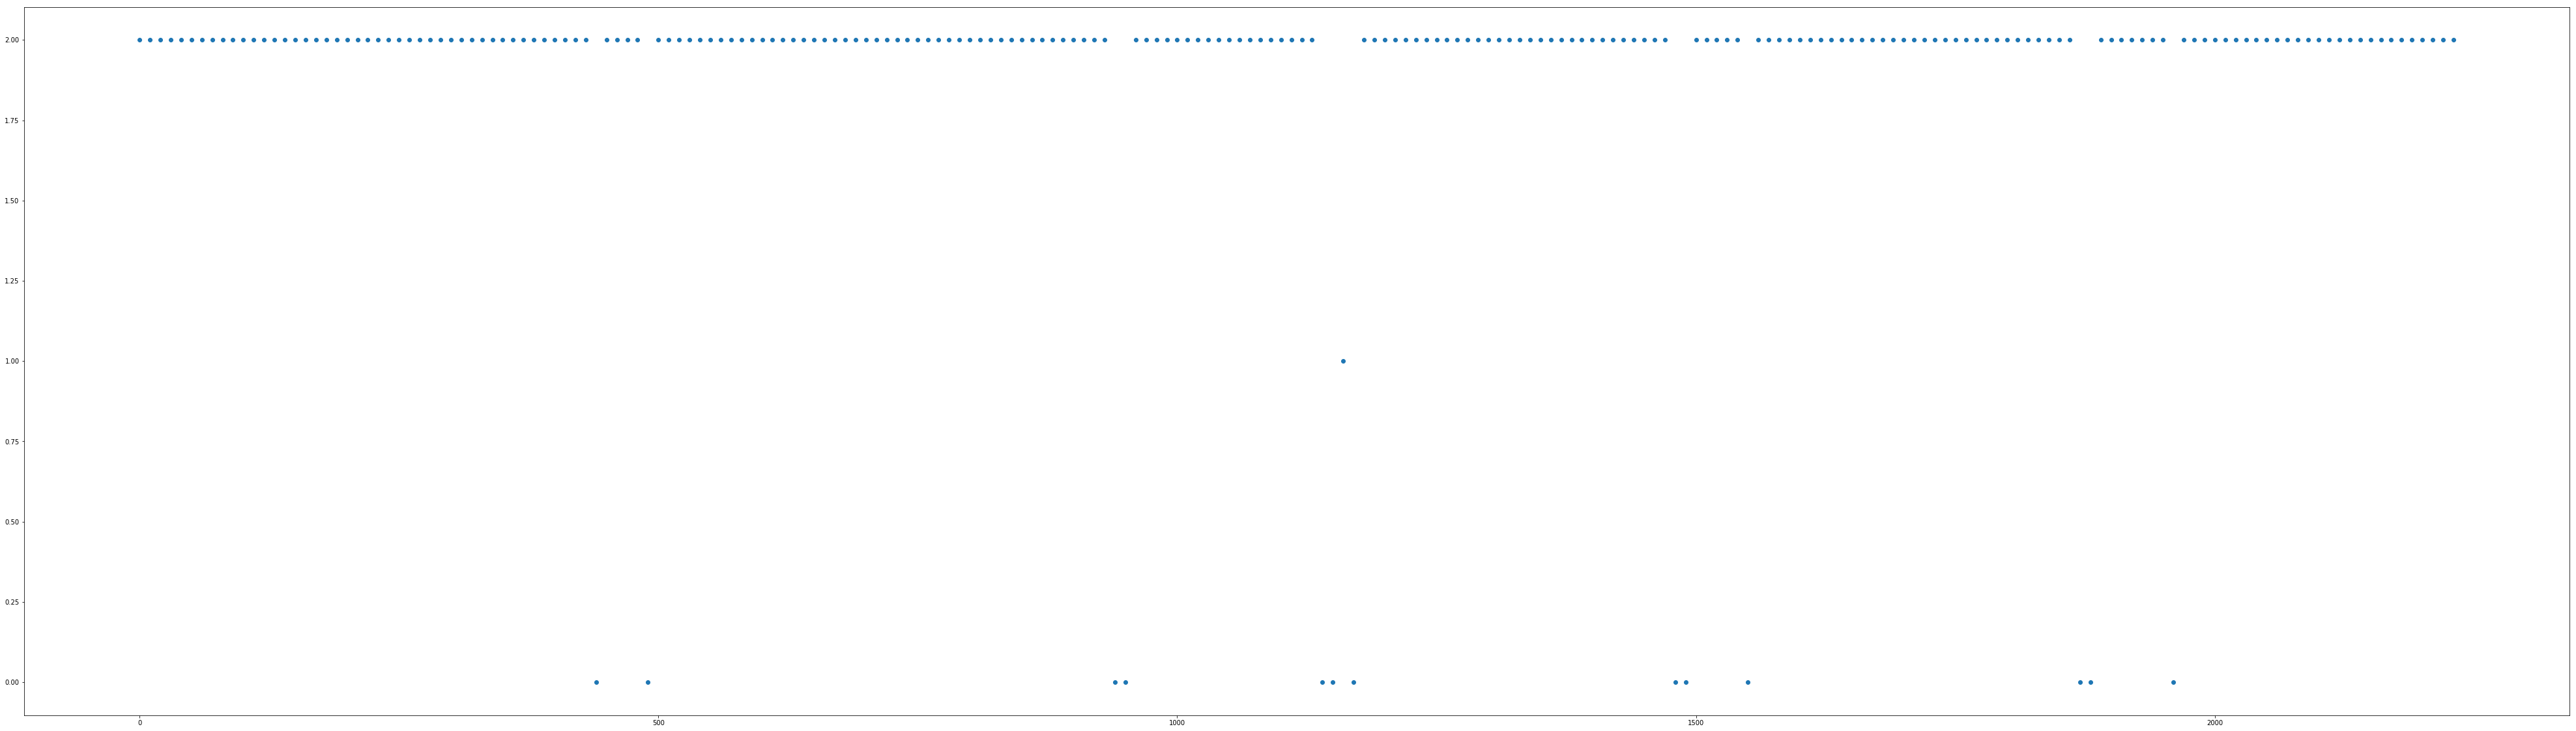

data/hitesh/hi_6.wav
1    197
0     22
Name: 0, dtype: int64
Speaker classified:  clusters/hi_5.wav


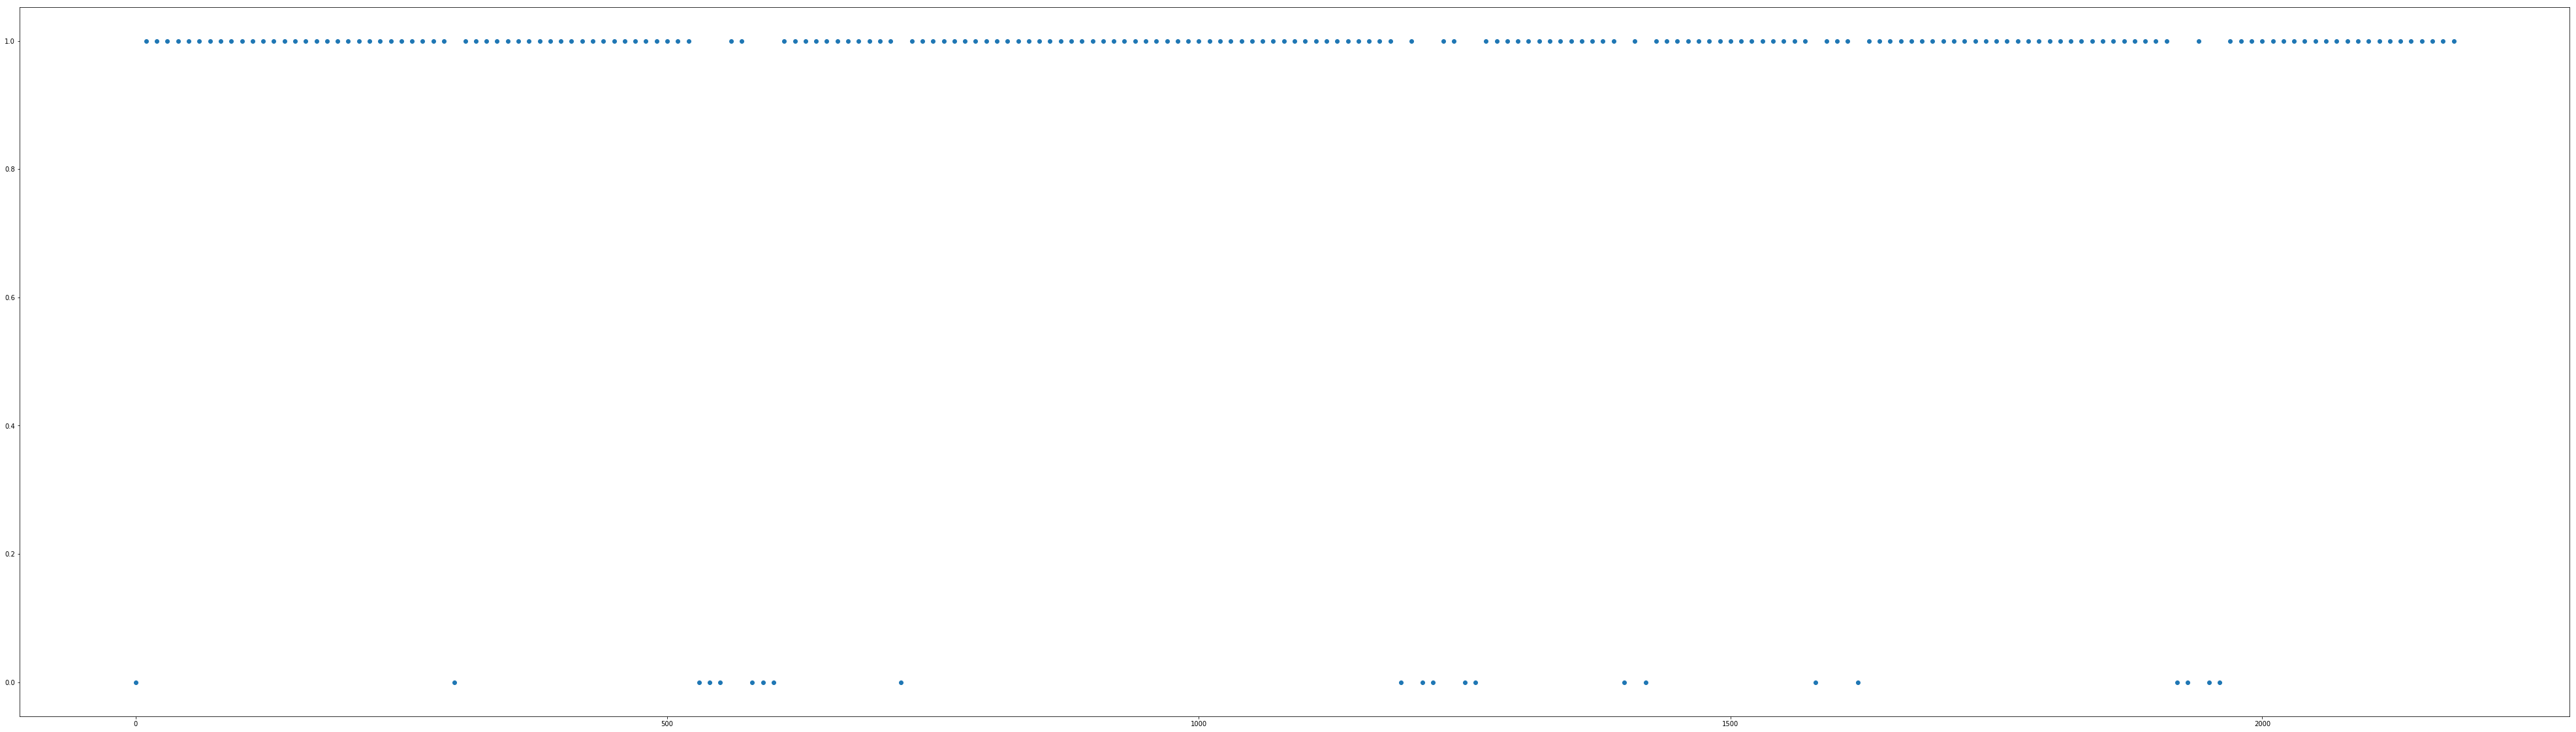

In [26]:
import os
import _pickle as cPickle
import numpy as np
from scipy.io.wavfile import read
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
import matplotlib.pyplot as plt

def extract_features(audio,rate):
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,41,appendEnergy = True,nfft=1500)
    mfcc_feat=np.array(pd.DataFrame(mfcc_feat).drop(0,axis=1))
    mfcc_feat = preprocessing.scale(mfcc_feat)
    return mfcc_feat

modelpath = "clusters/"

test_file = "test.txt"        

file_paths = open(test_file,'r',encoding='utf-8-sig')


gmm_files = [os.path.join(modelpath,fname) for fname in 
              os.listdir(modelpath) if fname.endswith('.kme')]

#Load the Gaussian gender Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [fname.split("\\")[-1].split(".kme")[0] for fname 
              in gmm_files]

# Read the test directory and get the list of test audio files 
for path in file_paths:   
    
    path = path.strip()   
    print (path)
    sr,audio = read(path)
    vector   = extract_features(audio,sr)
    out = []
    for x in (range(0,vector.shape[0],10)):
        z = vector[x:x+20]
        log_likelihood = np.zeros(len(models)) 
        for i in range(len(models)):
            kmeans    = models[i]         #checking with each model one by one
            scores = np.array(kmeans.score(z))
            log_likelihood[i] = scores
        winner = np.argmax(log_likelihood)
        out.append(winner)
    pd.DataFrame(out)[0].unique()
    print(pd.DataFrame(out)[0].value_counts())
    print("Speaker classified: ", speakers[(pd.DataFrame(out)[0].value_counts().index[0])])
    f,ax = plt.subplots(1,1,figsize=(70,20))
    ax.scatter(x = np.arange(0,vector.shape[0],10),y=out)
    plt.show()

0    542
2    421
1    384
Name: 0, dtype: int64
Speaker classified:  clusters/al_5.wav


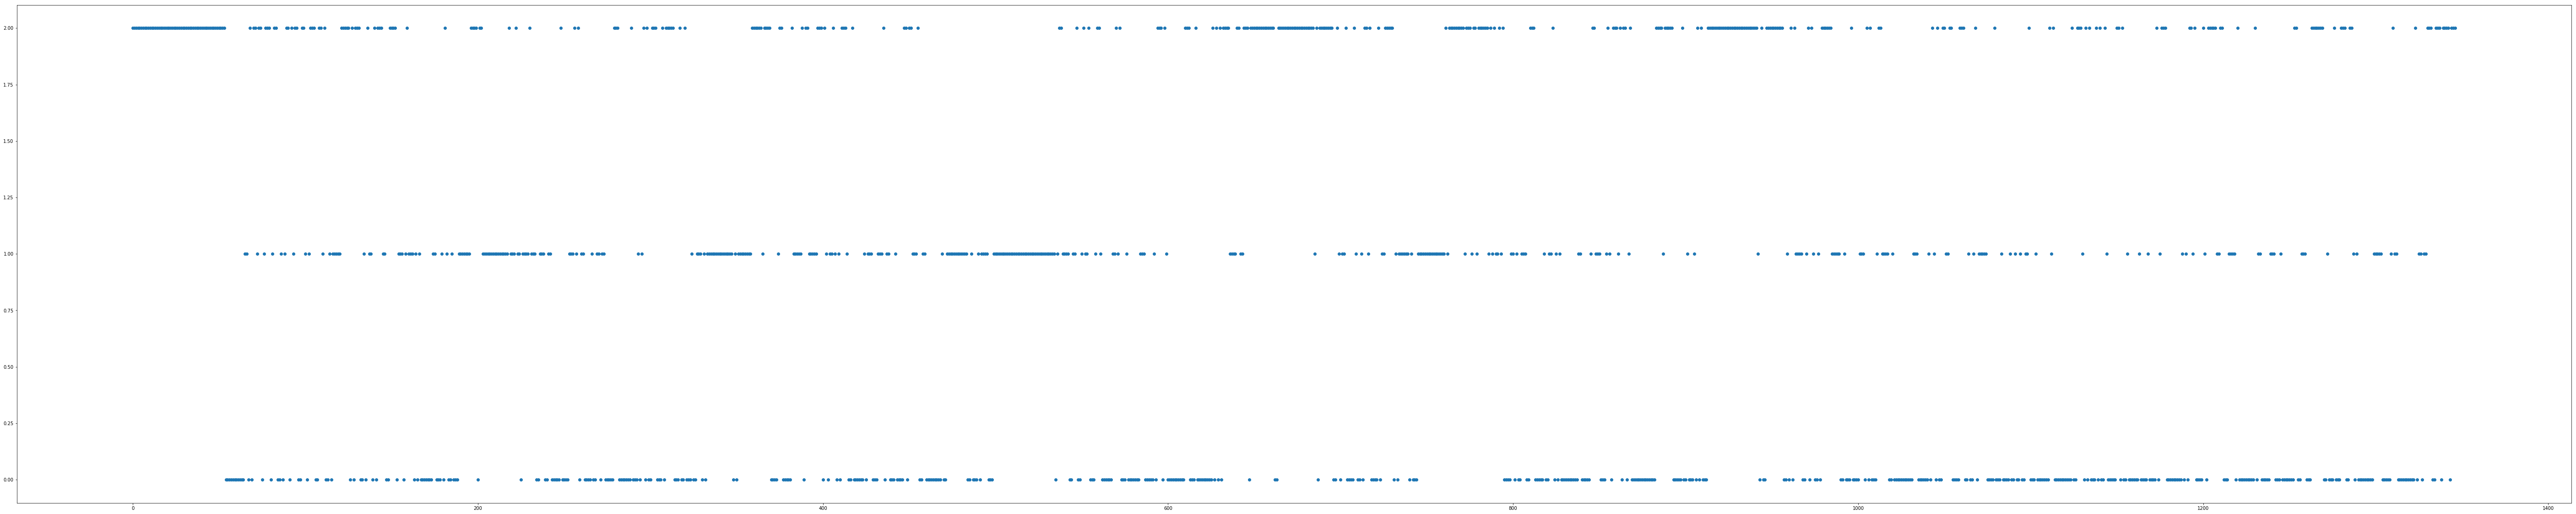

In [48]:
modelpath = "clusters/"


gmm_files = [os.path.join(modelpath,fname) for fname in 
              os.listdir(modelpath) if fname.endswith('.kme')]

#Load the Gaussian gender Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [fname.split("\\")[-1].split(".kme")[0] for fname 
              in gmm_files]

# Read the test directory and get the list of test audio files 

sr,audio = read("2_pitches.wav")
vector   = extract_features(audio,sr)
out = []
for x in (range(0,vector.shape[0],1)):
    z = vector[x]
    log_likelihood = np.zeros(len(models)) 
    for i in range(len(models)):
        kmeans    = models[i]         #checking with each model one by one
        scores = np.array(kmeans.score(z.reshape(1,-1)))
        log_likelihood[i] = scores
    winner = np.argmax(log_likelihood)
    out.append(winner)
pd.DataFrame(out)[0].unique()
print(pd.DataFrame(out)[0].value_counts())
print("Speaker classified: ", speakers[(pd.DataFrame(out)[0].value_counts().index[0])])
f,ax = plt.subplots(1,1,figsize=(100,20))
ax.scatter(x = np.arange(0,vector.shape[0],1),y=out)
plt.show()

In [50]:
time = np.arange(0,vector.shape[0],1)
time = time.tolist()

from itertools import groupby
L = out
grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
cluster_time = []
time_seperate = []
k=0
counter=0
for i in grouped_L:
    cluster_time.append(i[1])
for i in cluster_time:
    j=0
    first = time[k]
    while (j != i):
        k +=1
        j+=1
    last = time[k-1]
    time_seperate.append([first,last,i,grouped_L[counter][0]])
    counter +=1
def sortThird(val): 
    return val[2] 
time_seperate.sort(key = sortThird, reverse = True)

cluster_0 = []
cluster_1 = []
cluster_2 = []

for i in range (0,len(time_seperate)):
    if time_seperate[i][3] == 1:
        cluster_1.append(time_seperate[i])
    if time_seperate[i][3] == 0:
        cluster_0.append(time_seperate[i])
    if time_seperate[i][3] == 2:
        cluster_2.append(time_seperate[i])        
        
cluster_slice = [cluster_0[0],cluster_1[0],cluster_2[0]]
from pydub import AudioSegment
for i in range(0,len(cluster_slice)):
    t1 = cluster_slice[i][0]*10/2
    t2 = cluster_slice[i][1]*10/2
    newAudio = AudioSegment.from_wav("2_pitches.wav")
    newAudio = newAudio[t1:t2]
    newAudio.export('Obama_2_'+str(i)+'.wav', format="wav")

## Original Audio

In [51]:
import librosa
# function to load files and extract features
file_name = "2_pitches.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

## Sliced Audio: Detecting Notes

In [52]:
import librosa
# function to load files and extract features
file_name = "Obama_2_0.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

In [53]:
import librosa
# function to load files and extract features
file_name = "Obama_2_1.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

In [54]:
import librosa
# function to load files and extract features
file_name = "Obama_2_2.wav"
file = os.path.join(file_name)

# allowing playing of the loaded file
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
x, sr = librosa.load(file_name)
ipd.Audio(x, rate=sr)

In [46]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools

In [47]:
fig = tools.make_subplots(rows = 1, cols = 1)
p1 = go.Scatter(x =np.arange(vector.shape[0]) ,
        y = out,
        mode = 'markers', showlegend = False)
fig.append_trace(p1,1, 1)
fig['layout'].update(height = 800, width = 1500)
py.plot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



'temp-plot.html'